In [1]:
import classes
import caffemodel2pytorch as caffe

# modified visualpriors library
from transforms import VisualPriorRepresentation, VisualPriorPredictedLabel
from taskonomy_network import TaskonomyEncoder, TaskonomyDecoder

import os
import collections
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torchsummary

from PIL import Image
from scipy.stats import pearsonr
from scipy.io import savemat

import torchvision.io
import torch.utils.model_zoo # required to load nets
import torchvision.transforms.functional as TF
from torch import nn
import torchvision.models
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

#%load_ext autoreload
#%autoreload 2

In [2]:
"""
To check that the implementation of the code is correct, the analysis of vgg16_playes net is repeated here,
which should reproduce the same results as in the matlab implementation.

The boilerplate code for this is a bit different, since the vgg16_places model is imported from a different source
and in a different format than the Taskonomy models.

As soon as the model is brought into the right format, the analysis steps are the same in principle.
"""

'\nTo check that the implementation of the code is correct, the analysis of vgg16_playes net is repeated here,\nwhich should reproduce the same results as in the matlab implementation.\n\nThe boilerplate code for this is a bit different, since the vgg16_places model is imported from a different source\nand in a different format than the Taskonomy models.\n\nAs soon as the model is brought into the right format, the analysis steps are the same in principle.\n'

# Import model into replicated architecture

In [3]:
vgg16_places = nn.Sequential(
    collections.OrderedDict(
        [
            ('conv1_1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('ReLU1_1', nn.ReLU()),
            ('conv1_2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('ReLU1_2',nn.ReLU()),
            ('MaxPool1', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv2_1',nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('ReLU2_1',nn.ReLU()),
            ('conv2_2',nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('ReLU2_2',nn.ReLU()),
            ('MaxPool2', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv3_1', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_1',nn.ReLU()),
            ('conv3_2', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_2',nn.ReLU()),
            ('conv3_3', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_3',nn.ReLU()),
            ('MaxPool3', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv4_1', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_1',nn.ReLU()),
            ('conv4_2', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_2',nn.ReLU()),
            ('conv4_3', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_3',nn.ReLU()),
            ('MaxPool4', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv5_1', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_1',nn.ReLU()),
            ('conv5_2', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_2',nn.ReLU()),
            ('conv5_3', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_3',nn.ReLU()),
            ('MaxPool5', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('Flatten6', nn.Flatten()),
            ('fc6', nn.Linear(in_features=25088, out_features=4096)),
            ('ReLU6',nn.ReLU()),
            ('fc7', nn.Linear(in_features=4096, out_features=4096)),
            ('ReLU7',nn.ReLU()),
            ('fc8a', nn.Linear(in_features=4096, out_features=365)),
            ('Softmax8a', nn.Softmax(dim=-1))
        ]
    )
)

Sequential(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1_2): ReLU()
  (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2_2): ReLU()
  (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU3_3): ReLU()
  (MaxPool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(

In [4]:
vgg16_places_statedict = torch.load('vgg16_places365.caffemodel.pt')
vgg16_places.load_state_dict(vgg16_places_statedict)

<All keys matched successfully>

# Build model for extracting layer activations

In [5]:
_, eval_nodes = get_graph_node_names(vgg16_places)
#for node in eval_nodes:
#    print(node, end='   ')

return_nodes = { node:node for node in eval_nodes if "conv" in node or 'fc' in node}

vgg16_places_fe = create_feature_extractor(vgg16_places, return_nodes=return_nodes)

input   conv1   ReLU1   conv1_1   ReLU1_1   MaxPool1   conv2   ReLU2   conv2_1   ReLU2_1   MaxPool2   conv3   ReLU3   conv3_1   ReLU3_1   conv3_2   ReLU3_2   MaxPool3   conv4   ReLU4   conv4_1   ReLU4_1   conv4_2   ReLU4_2   MaxPool4   conv5   ReLU5   conv5_1   ReLU5_1   conv5_2   ReLU5_2   MaxPool5   Flatten6   fc6   ReLU6   fc7   ReLU7   fc8a   Softmax8a   

In [11]:
torchsummary.summary(vgg16_places_fe, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Perform analysis

In [6]:
places_images = classes.ImageDataset('./data/stimuli_places1', beauty_ratings_path='./behavior/ratings_study1.csv')
integration_calc = classes.IntegrationCalculatorVGG16(vgg16_places_fe, return_nodes)

In [8]:
results_vgg16 = classes.calculate_dataset_integration(places_images, integration_calc)

In [10]:
results_vgg16.to_csv('./results/vgg16_places/vgg16_places_results.csv')

In [ ]:
results_vgg16 = pd.read_csv('./results/vgg16_places/vgg16_places_results.csv')

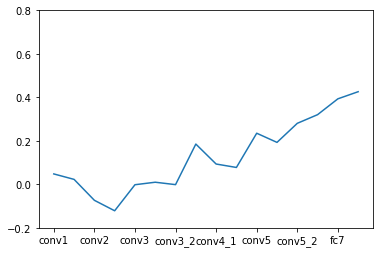

In [18]:
classes.correlate_integration_beauty(results_vgg16, places_images.beauty_ratings).plot(ylim=(-.2,.8))